In [10]:

import torch
import torch.nn as nn
import torch.optim as optim
from adan_pytorch import Adan
import copy
from utils import preparte_data_loader
from utils import set_parameter_requires_grad
from utils import DEVICE
import time
# from utils import BertForSequenceLabeling
from transformers import BertModel, BertConfig
import matplotlib.pyplot as plt

In [2]:
output_dim = 50
LOSS_CRITERIA = nn.CrossEntropyLoss()

In [3]:
class BertForSequenceLabeling(nn.Module):
    def __init__(self, num_labels=50):
        super(BertForSequenceLabeling, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        set_parameter_requires_grad(self.bert, feature_extracting=True)
        end_input_features = self.bert.pooler.dense.in_features
        self.bert.pooler.dense = nn.Linear(end_input_features,num_labels)
        self.num_labels = num_labels  # Store num_labels as an instance variable

    def forward(self, input_ids, attention_mask=None):
        # Transform the embeddings to BERT-compatible dimensions
        # Pass through BERT
        outputs = self.bert(inputs_embeds=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state  # Shape: (batch_size, max_length, hidden_size)
        
        # Prepare logits for sequence labeling
        logits = self.bert.pooler.dense(sequence_output)  # Shape: (batch_size, max_length, num_labels)
        return logits


### double check our model to ensure the only train samples are for the last part

In [35]:
bert_model = BertForSequenceLabeling()
bert_model = bert_model.to(DEVICE)

params_to_update = bert_model.parameters()
print("Params to learn:")
# if feature_extract:
params_to_update = []  # override the initial list definition above
for name,param in bert_model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 bert.pooler.dense.weight
	 bert.pooler.dense.bias


In [15]:
def train_model(model, dataloaders, optimizer, num_epochs=25, device=DEVICE, loss_criteria = LOSS_CRITERIA):
    since = time.time()

    val_acc_history = []
    training_loss = []
    

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = loss_criteria(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                training_loss.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, training_loss, val_acc_history

In [12]:
optimizer = optim.Adam(bert_model.parameters(), lr=3e-3)
train_dataloader = preparte_data_loader(mode='train', batch_size=20)
val_dataloader = preparte_data_loader(mode='val', batch_size=20)
dataloaders = {
    'train':train_dataloader,
    'val':val_dataloader
}


1200
400


In [7]:
# for inputs, labels in dataloaders['train']:
#     print(inputs)
#     print(labels)
#     break

In [13]:
%matplotlib inline
def plot_results(train_losses,val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [16]:
model, training_loss, val_acc_history = train_model(bert_model, dataloaders, optimizer, num_epochs=2, device=DEVICE, loss_criteria = LOSS_CRITERIA)


Epoch 0/1
----------
train Loss: 4.0671 Acc: 11.4992
val Loss: 3.3950 Acc: 39.9900

Epoch 1/1
----------
train Loss: 4.0462 Acc: 11.3642
val Loss: 3.2961 Acc: 40.5650

Training complete in 1m 29s
Best val Acc: 40.565000


In [33]:
import numpy as np
training_loss = [i.cpu().numpy().tolist() for i in training_loss]
val_acc_history = [i.cpu().numpy().tolist() for i in val_acc_history]

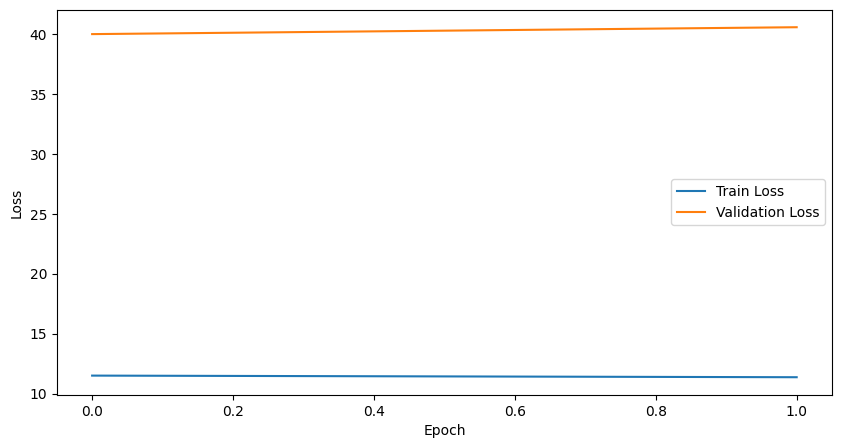

In [34]:
plot_results(training_loss, val_acc_history)

In [ ]:
# optim.Adam(model.parameters(), lr=3e-4)
# torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
# optim = Adan(model.parameters(),lr = 1e-3,                  # learning rate (can be much higher than Adam, up to 5-10x)
#     betas = (0.02, 0.08, 0.01), # beta 1-2-3 as described in paper - author says most sensitive to beta3 tuning
#     weight_decay = 0.02         # weight decay 0.02 is optimal per author
# )